In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score


LOAD THE DATASETS

In [16]:
datasets = {}
paths = sorted(glob.glob("Dataset2/*.csv"))

for i, p in enumerate(paths):
    datasets[f"dataset_{i+1}"] = pd.read_csv(p)


VISUALISE RAW DATASETS

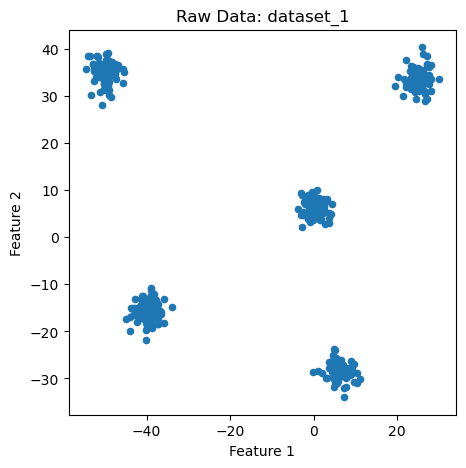

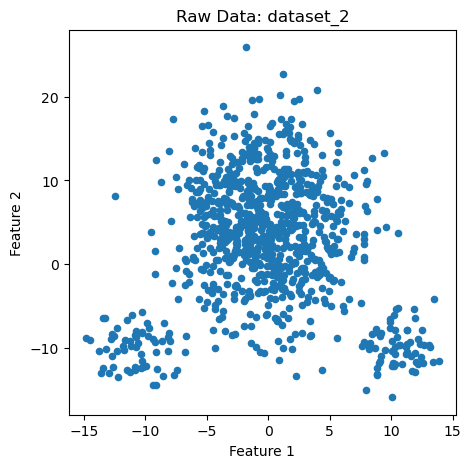

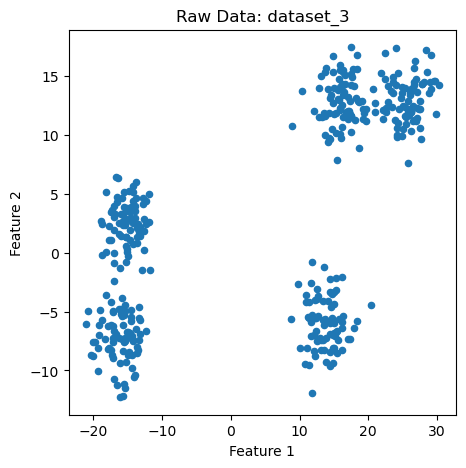

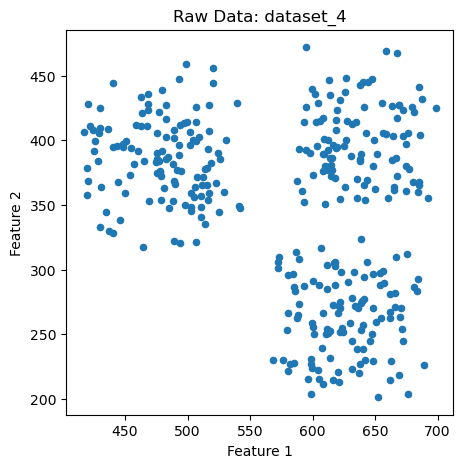

In [17]:
for name, df in datasets.items():
    plt.figure(figsize=(5, 5))
    plt.scatter(df.iloc[:, 0], df.iloc[:, 1], s=20)
    plt.title(f"Raw Data: {name}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

FUNCTION FOR CLUSTERING ALGORITHMS

In [18]:
def apply_clustering(df, dataset_name):

    X = df.values
    results = []
    
    # ------------------ K-MEANS ------------------
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans_labels = kmeans.fit_predict(X)
    km_sil = silhouette_score(X, kmeans_labels)

    plt.figure(figsize=(5, 5))
    plt.scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis')
    plt.title(f"{dataset_name} - KMeans")
    plt.show()

    results.append(["KMeans", km_sil, None])
# ------------------ AGGLOMERATIVE ------------------
    agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
    agg_labels = agg.fit_predict(X)
    agg_sil = silhouette_score(X, agg_labels)

    plt.figure(figsize=(5, 5))
    plt.scatter(X[:, 0], X[:, 1], c=agg_labels, cmap='viridis')
    plt.title(f"{dataset_name} - Agglomerative")
    plt.show()

    results.append(["Agglomerative", agg_sil, None])


    # ------------------ DBSCAN (AUTO SEARCH) ------------------
    best_dbscan_sil = -1
    best_noise = None
    best_params = None
    best_labels = None

    for eps in range(1, 6):
        for ms in [3, 5, 10, 15, 20]:

            db = DBSCAN(eps=eps, min_samples=ms)
            labels = db.fit_predict(X)

            mask = labels != -1  # ignore noise

            if len(set(labels[mask])) < 2:
                continue

            sil = silhouette_score(X[mask], labels[mask])

            if sil > best_dbscan_sil:
                best_dbscan_sil = sil
                best_noise = np.sum(labels == -1)
                best_params = (eps, ms)
                best_labels = labels

    # Plot DBSCAN
    plt.figure(figsize=(5, 5))
    plt.scatter(X[:, 0], X[:, 1], c=best_labels, cmap='viridis')
    plt.title(f"{dataset_name} - DBSCAN (eps={best_params[0]}, min_samples={best_params[1]})")
    plt.show()

    results.append(["DBSCAN", best_dbscan_sil, best_noise])

    return results, best_params


RUN ON DATASETS



=== PROCESSING dataset_1 ===


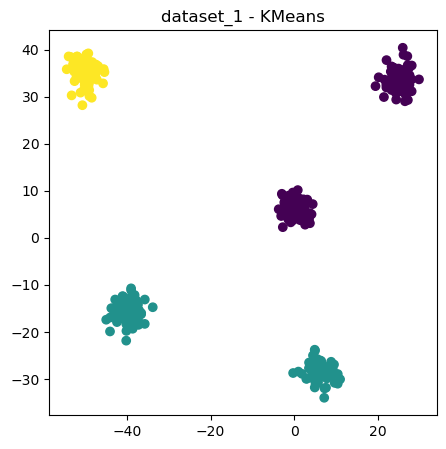

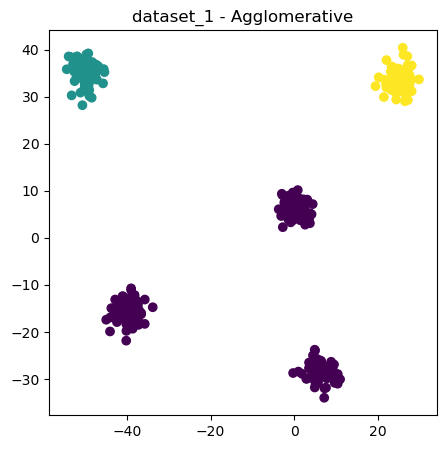

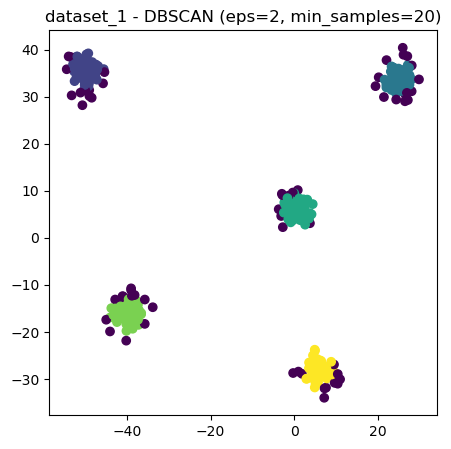



=== PROCESSING dataset_2 ===


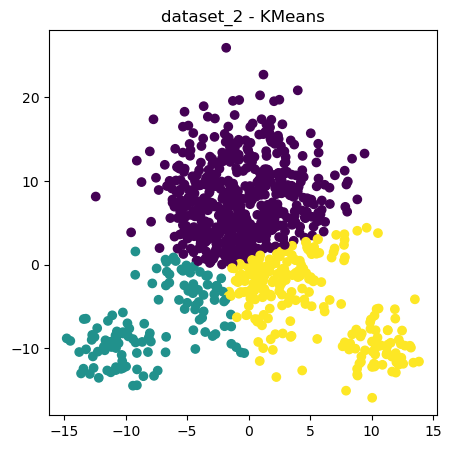

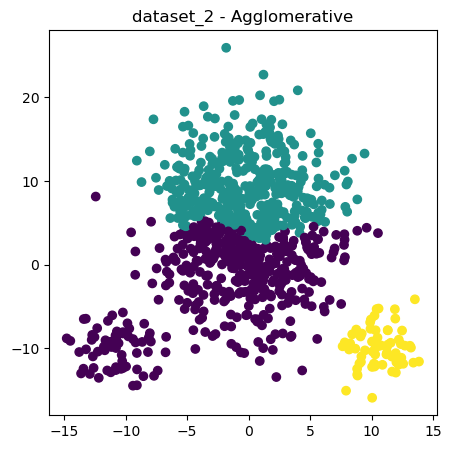

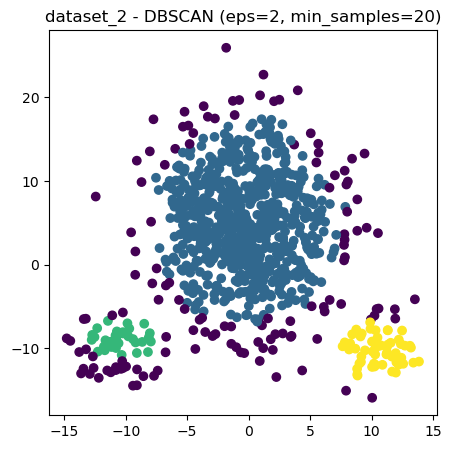



=== PROCESSING dataset_3 ===


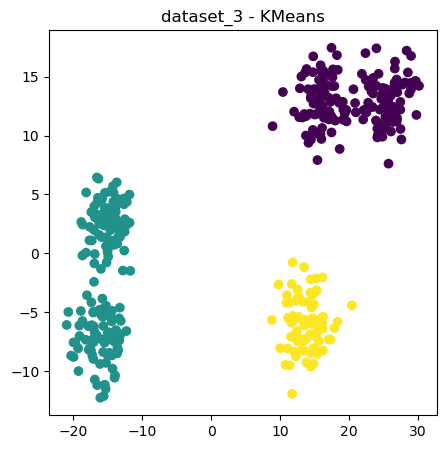

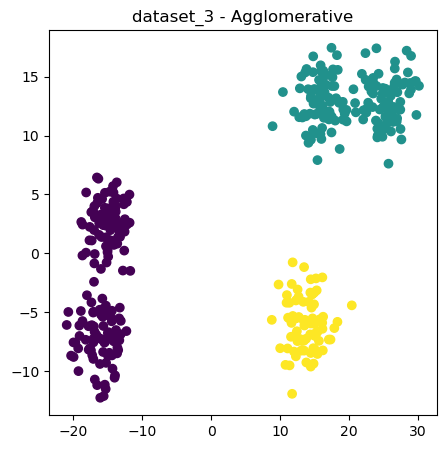

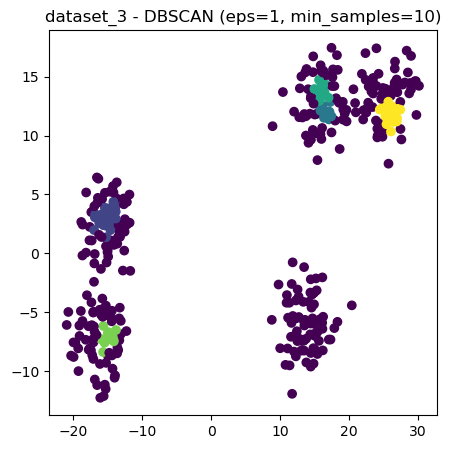



=== PROCESSING dataset_4 ===


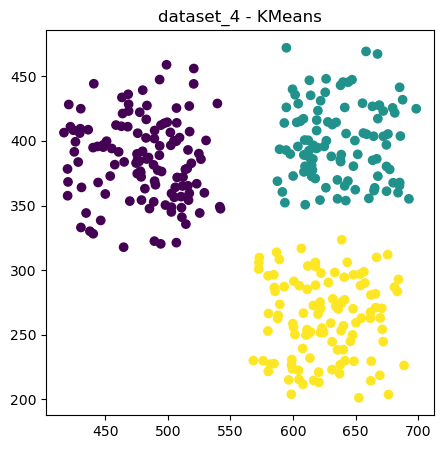

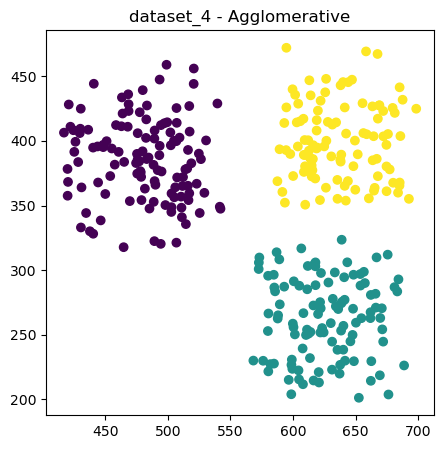

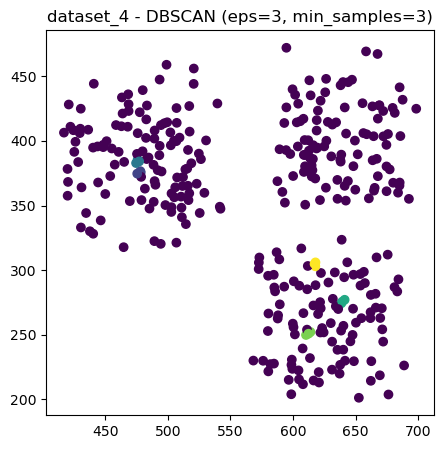

In [19]:
final_scores = []
dbscan_params = {}

for name, df in datasets.items():

    print(f"\n\n=== PROCESSING {name} ===")
    res, params = apply_clustering(df, name)

    for r in res:
        final_scores.append([name] + r)

    dbscan_params[name] = params

SCORE TABLE

In [20]:
sil_df = pd.DataFrame(final_scores,
                      columns=["Dataset", "Algorithm", "Silhouette Score", "Noise Points"])
sil_df

,Dataset,Algorithm,Silhouette Score,Noise Points
0,dataset_1,KMeans,0.630720,NaN
1,dataset_1,Agglomerative,0.610037,NaN
2,dataset_1,DBSCAN,0.927390,61.0
3,dataset_2,KMeans,0.430766,NaN
4,dataset_2,Agglomerative,0.372080,NaN
5,dataset_2,DBSCAN,0.544984,130.0
6,dataset_3,KMeans,0.738949,NaN
7,dataset_3,Agglomerative,0.738949,NaN
8,dataset_3,DBSCAN,0.772024,310.0
9,dataset_4,KMeans,0.613946,NaN


In [ ]:
ADDITIONAL METRIC-SUM OF INTRA-CLUSTER DISTANCES

In [21]:
def intra_cluster_distance(X, labels):
    total = 0
    for c in np.unique(labels):
        if c == -1: 
            continue
        pts = X[labels == c]
        center = pts.mean(axis=0)
        total += np.sum(np.sqrt(np.sum((pts - center)**2, axis=1)))
    return total


metric_results = []

for name, df in datasets.items():

    print(f"\nDataset: {name}")
    X = df.values

    km = KMeans(n_clusters=3).fit(X)
    metric_results.append([name, "KMeans", intra_cluster_distance(X, km.labels_)])

    agg = AgglomerativeClustering(n_clusters=3).fit(X)
    metric_results.append([name, "Agglomerative", intra_cluster_distance(X, agg.labels_)])

    eps, ms = dbscan_params[name]
    db = DBSCAN(eps=eps, min_samples=ms).fit(X)
    metric_results.append([name, "DBSCAN", intra_cluster_distance(X, db.labels_)])


metric_df = pd.DataFrame(metric_results,
                         columns=["Dataset", "Algorithm", "Intra-cluster Distance"])
metric_df


Dataset: dataset_1

Dataset: dataset_2

Dataset: dataset_3

Dataset: dataset_4


,Dataset,Algorithm,Intra-cluster Distance
0,dataset_1,KMeans,7005.172730
1,dataset_1,Agglomerative,6370.997822
2,dataset_1,DBSCAN,700.067354
3,dataset_2,KMeans,4892.691228
4,dataset_2,Agglomerative,4813.731207
5,dataset_2,DBSCAN,4022.692988
6,dataset_3,KMeans,1900.026852
7,dataset_3,Agglomerative,1900.026852
8,dataset_3,DBSCAN,74.988992
9,dataset_4,KMeans,13257.360316
